In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import factor_analyzer as fa
import copy

tss_df = pd.read_csv("data/combined_data.csv")
items_descr = pd.read_csv("data/description_items.csv")

tss_df.drop(columns="Unnamed: 0", inplace=True)

items_descr.set_index("Unnamed: 0", drop=True, inplace=True)
items_descr.index.set_names("item_label", inplace=True)
items_descr = pd.Series(items_descr.iloc[:, 0], name="item description")

tss_df.head(3)

response_id   story_id        prompt_label preset_label     sample  \
0  R_3LZPTbqxmeWvp7w   GEN_HF_6        High Fantasy      Genesis  Community   
1  R_3CCMkj9T7UgOtgP   ALL_HR_3  Historical Romance  All-Nighter  Community   
2  R_3PBKFhmDXlAQNO6  ALL_HOR_2              Horror  All-Nighter  Community   

   tss_coh_1  tss_coh_2  tss_coh_3  tss_coh_4  tss_coh_5  ...  \
0        2.0        4.0        4.0          4        4.0  ...   
1        2.0        4.0        2.0          1        2.0  ...   
2        5.0        5.0        1.0          1        3.0  ...   

                 start                  end  duration_in_sec  \
0  2022-02-17 07:41:22  2022-02-17 07:58:46             1044   
1  2022-02-17 07:52:11  2022-02-17 08:01:19              548   
2  2022-02-17 07:55:22  2022-02-17 08:03:16              473   

              recorded                                          tss_order  \
0  2022-02-17 07:58:47  1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|1...   
1  2022-02-17 08:01:20  1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|1...   
2  2022-02-17 08:03:16  1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|1...   

   qual_check_1  qual_check_1_order  qual_check_2  pass_qual_1  pass_qual_2  
0           NaN                 NaN           NaN          NaN          NaN  
1           NaN                 NaN           NaN          NaN          NaN  
2           NaN                 NaN           NaN          NaN          NaN  

[3 rows x 92 columns]

In [2]:
item_labels_li = [
    'tss_coh_1', 'tss_coh_2', 'tss_coh_3', 'tss_coh_4',
    'tss_coh_5', 'tss_coh_6', 'tss_coh_7', 'tss_coh_8', 'tss_coh_9',
    'tss_coh_10', 'tss_coh_11', 'tss_coh_12', 'tss_conch_1', 'tss_conch_2',
    'tss_conch_3', 'tss_conch_4', 'tss_conch_5', 'tss_conch_6',
    'tss_conch_7', 'tss_conch_8', 'tss_cre_1', 'tss_cre_2', 'tss_cre_3',
    'tss_cre_4', 'tss_cre_5', 'tss_cre_6', 'tss_cre_7', 'tss_cre_8',
    'tss_cre_9', 'tss_cre_10', 'tss_cre_11', 'tss_cre_12', 'tss_qua_1',
    'tss_qua_2', 'tss_qua_3', 'tss_qua_4', 'tss_qua_5', 'tss_qua_6',
    'tss_qua_7', 'tss_qua_8', 'tss_rep_1', 'tss_rep_2', 'tss_rep_3',
    'tss_rep_4', 'tss_rep_5', 'tss_rep_6', 'tss_rep_7', 'tss_rep_8',
    'tss_rep_9', 'tss_rep_10', 'tss_rep_11', 'tss_rep_12', 'tss_sty_1',
    'tss_sty_2', 'tss_sty_3', 'tss_sty_4', 'tss_sty_5', 'tss_sty_6',
    'tss_sty_7', 'tss_sty_8', 'tss_sty_9', 'tss_sty_10', 'tss_sty_11',
    'tss_sty_12', 'tss_pac_1', 'tss_pac_2', 'tss_pac_3', 'tss_pac_4',
    'tss_pac_5', 'tss_pac_6', 'tss_pac_7', 'tss_pac_8', 'tss_pac_9'
]


# check if items are appropriate for EFA
# correlations mostly |.3|-|.8|
items_corr = tss_df[item_labels_li].corr()

extreme_corrs_count_dict = {}
high_corr_li = []

# print out extreme corrs
total_report = ""
for index, row in items_corr.iterrows():
    variable1 = index
    corrs = row
    i = 0
    count = 0
    for variable2, corr in corrs.iteritems():
        if (variable1 != variable2) and ((abs(corr) < 0.3) or (abs(corr) > 0.8)):
            count += 1
            if abs(corr) > 0.8:
                high_corr_li.append((variable1, variable2, corr))
        i += 1
    extreme_corrs_count_dict[variable1] = count

extreme_corrs_count = pd.Series(extreme_corrs_count_dict)
print("Descriptives for extreme correlation count:")
print(extreme_corrs_count.describe())

# uhmm that are more extreme correlations as I would like
# but maybe subscales are fairly orthogonal?

Descriptives for extreme correlation count:
count    73.000000
mean     50.054795
std       9.814799
min      29.000000
25%      43.000000
50%      52.000000
75%      57.000000
max      68.000000
dtype: float64


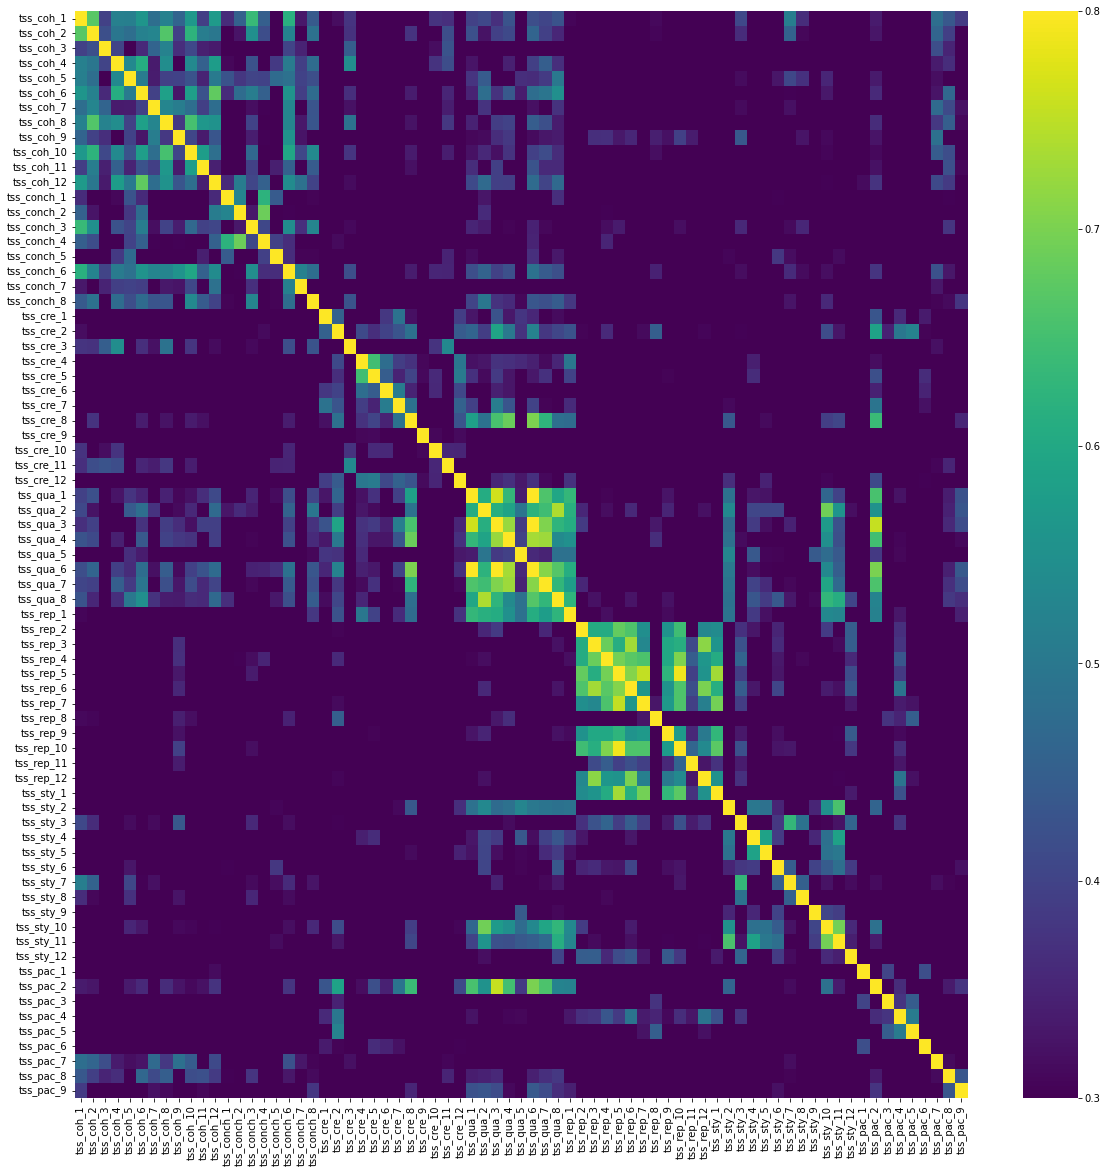

In [3]:
# Let us look at a heatmap (absolute values of correlations)
fig, ax = plt.subplots(figsize=(20, 20))

ax = sns.heatmap(abs(items_corr),
                 xticklabels=items_corr.columns.values,
                 yticklabels=items_corr.columns.values,
                 ax=ax, cmap="viridis", vmin=0.3, vmax=0.8)

# most item clusters are just surprising orthogonal (which is actually nice)

In [4]:
# Inspect suspicious items with low correlations here
susp_items = [
    "tss_cre_9", "tss_cre_10", "tss_cre_12",
    "tss_rep_8",
    "tss_pac_1", "tss_pac_3", "tss_pac_5", "tss_pac_6"
]

for index, row in items_corr.iterrows():
    if index in susp_items:
        print("{}: {}".format(index, items_descr[index]))
        print("Correlations >= .3:")
        if row[(row >= .3) & (row.index != index)].empty:
            print("NONE - ALL correlations are < .3!")
        else:
            print(row[(row > .3) & (row.index != index)].to_string())
        print("")

tss_cre_9: The setting of the story was original.
Correlations >= .3:
tss_cre_4     0.309678
tss_cre_5     0.310210
tss_cre_10    0.309258
tss_cre_12    0.312230

tss_cre_10: The story was unconventional.
Correlations >= .3:
tss_coh_1      0.373531
tss_conch_6    0.351974
tss_cre_5      0.357607
tss_cre_6      0.355118
tss_cre_9      0.309258
tss_cre_12     0.351737
tss_pac_7      0.300408

tss_cre_12: The story was innovative.
Correlations >= .3:
tss_cre_1     0.391432
tss_cre_4     0.498742
tss_cre_5     0.506019
tss_cre_6     0.408326
tss_cre_7     0.454762
tss_cre_8     0.428954
tss_cre_9     0.312230
tss_cre_10    0.351737
tss_qua_3     0.352412
tss_qua_4     0.369981
tss_qua_5     0.331850
tss_qua_6     0.369852
tss_qua_7     0.310435
tss_rep_1     0.371961
tss_sty_2     0.365033
tss_sty_5     0.346125
tss_sty_10    0.306401
tss_pac_2     0.410418
tss_pac_6     0.302361

tss_rep_8: The plot had no development.
Correlations >= .3:
tss_coh_1      0.310659
tss_coh_2      0.306662
ts

In [5]:
# Consider excluding variables with lots correlations < .3
items_analysis_li = copy.deepcopy(item_labels_li)

excluded_items_li = [
    "tss_cre_9"
]

for item in excluded_items_li:
    items_analysis_li.remove(item)

In [6]:
# Check for multicollinearity
print("\nHigh pairs of correlation")
for entry in high_corr_li:
    print("{} <-> {}: {}".format(entry[0], entry[1], entry[2]))
items_corr = tss_df[items_analysis_li].corr()
print("\nDeterminant of correlation matrix: {}".format(np.linalg.det(items_corr)))

# Determinant should be > .00001


High pairs of correlation
tss_qua_1 <-> tss_qua_6: 0.8102444208310783
tss_qua_3 <-> tss_qua_6: 0.8230371360694376
tss_qua_6 <-> tss_qua_1: 0.8102444208310783
tss_qua_6 <-> tss_qua_3: 0.8230371360694376

Determinant of correlation matrix: 9.637264158670293e-30


In [7]:
# Disply item descriptions for items with high corr
high_corr_items = [
    "tss_qua_1", "tss_qua_3", "tss_qua_6"
]

for item in high_corr_items:
    print(item + ":")
    print(items_descr[item] + "\n")

tss_qua_1:
This story was enjoyable.

tss_qua_3:
The story was fun to read.

tss_qua_6:
I liked this story.



In [8]:
# Decide here whether to exclude items based on high correlations
# If determinant stays high I would keep that in mind and have a look at it once a solution stabilized
# item exclusion is often easier once you have an idea of what items you need for working subscales


excluded_items_li = [
    "tss_qua_6"
]

for item in excluded_items_li:
    items_analysis_li.remove(item)

items_corr = tss_df[items_analysis_li].corr()
print("\nNew determinant of correlation matrix: {}".format(
    np.linalg.det(items_corr)))


New determinant of correlation matrix: 9.059766471578426e-29


In [9]:
# Check Sampling Adequacy (KMO)
# (if SVD does not converge, dropna for participants with too many missing items)
# (might need to experiment how many missing are still okay)

tss_df.dropna(subset=items_analysis_li, thresh=38, inplace=True)

kmo = fa.factor_analyzer.calculate_kmo(tss_df[items_analysis_li])

print("Overall KMO: {}".format(kmo[1]))

i = 0
low_item_kmo = False
for item_kmo in kmo[0]:
    if item_kmo < .6:
        low_item_kmo = True
        item_label = item_labels_li[i]
        print("Low KMO for {} ('{}'): {}".format(
            item_label, items_descr[item_label], item_kmo))
    i += 1

if low_item_kmo == False:
    print("All item KMOs are >.6")

# Guidelines for KMO (Kaiser & Rice, 1974)
# Marvellous: values in the 0.90s
# Meritorious: values in the 0.80s
# Middling: values in the 0.70s
# Mediocre: values in the 0.60s
# Unacceptable: values in the 0.50s

Overall KMO: 0.8344212590640787
All item KMOs are >.6


C:\ProgramData\Anaconda3\lib\site-packages\factor_analyzer\utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


In [30]:
# Determine number of factors
# Code for parallel analysis adapted from Eric Andrews:
# https://stackoverflow.com/a/68677057


# EFA with no rotation and maximum number factors to get
efa = fa.factor_analyzer.FactorAnalyzer(rotation=None)
efa.fit(tss_df[items_analysis_li])
ev_pca, ev_efa = efa.get_eigenvalues()

# Prepare random data for parallel analysis
n, m = tss_df[items_analysis_li].shape
par_efa = fa.factor_analyzer.FactorAnalyzer(rotation=None)

# Create df to store the values
sum_par_evs = pd.DataFrame(columns=range(1, m+1))

k = 10
# Run the fit 'k' times over a random matrix
for runNum in range(0, k):
    par_efa.fit(np.random.normal(size=(n, m)))
    ev_ser = pd.Series(par_efa.get_eigenvalues()[1], index=sum_par_evs.columns)
    sum_par_evs = sum_par_evs.append(ev_ser, ignore_index=True)
# get 95th percentile for the evs
par_95per = sum_par_evs.quantile(0.95)

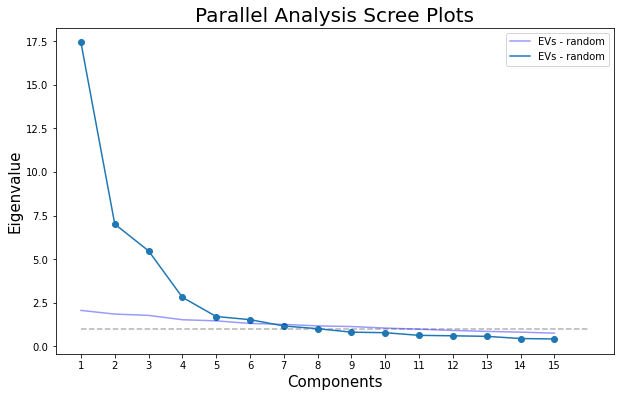

95th percentile of factor eigenvalues for 10 random matrices for first 15 factors:
1    2.06
2    1.85
3    1.78
4    1.53
5    1.46
6    1.32
7    1.26
8    1.18
9    1.14
10   1.05
11   0.99
12   0.91
13   0.86
14   0.82
15   0.76
Factor eigenvalues for survey data for first 15 factors:
1	17.42
2	7.01
3	5.47
4	2.81
5	1.71
6	1.53
7	1.17
8	1.01
9	0.82
10	0.78
11	0.63
12	0.61
13	0.58
14	0.45
15	0.43


In [71]:
# OUtput become too hard to read with too many factors
# Only display a part of the EVs
facs_to_display = 15

plt.figure(figsize=(10, 6))

# Line for eigenvalue 1
plt.plot([1, facs_to_display+1], [1, 1], 'k--', alpha=0.3)
# For the random data (parallel analysis)
plt.plot(range(1, len(par_95per[:facs_to_display])+1),
         par_95per[:facs_to_display], 'b', label='EVs - random', alpha=0.4)
# Markers and line for actual EFA eigenvalues
plt.scatter(
    range(1, len(ev_efa[:facs_to_display])+1), ev_efa[:facs_to_display])
plt.plot(range(1, len(ev_efa[:facs_to_display])+1),
         ev_efa[:facs_to_display], label='EVs - random')

plt.title('Parallel Analysis Scree Plots', {'fontsize': 20})
plt.xlabel('Components', {'fontsize': 15})
plt.xticks(ticks=range(1, facs_to_display+1),
           labels=range(1, facs_to_display+1))
plt.ylabel('Eigenvalue', {'fontsize': 15})
plt.legend()
plt.show()

print('95th percentile of factor eigenvalues for {} random matrices for first {} factors:\n{}'.format(
    k, facs_to_display, par_95per[:facs_to_display].to_string(float_format=lambda x: "{:.2f}".format(x))))
print('Factor eigenvalues for survey data for first {} factors:'.format(
    facs_to_display))
# Data EVs are stored in numpy array. For simplicity I just print them with a for loop
i = 1
for ev in ev_efa[:facs_to_display]:
      print("{}\t{:.2f}".format(i, ev))
      i += 1
    
# NEXT PRETTIFY THIS OUTPUT
# just make it a table...

In [18]:
sum_par_evs.describe()

1          2          3          4          5          6   \
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    1.892035   1.731565   1.620195   1.460757   1.365046   1.291000   
std     0.108259   0.063264   0.065307   0.045650   0.049886   0.024836   
min     1.741832   1.642545   1.553112   1.379849   1.313009   1.262020   
25%     1.810816   1.688613   1.556060   1.442326   1.332796   1.268721   
50%     1.885941   1.736946   1.610900   1.461162   1.340849   1.290217   
75%     1.952923   1.753716   1.681906   1.483875   1.389577   1.301537   
max     2.111374   1.849039   1.710192   1.540626   1.453199   1.333808   

              7          8          9          10  ...         62         63  \
count  10.000000  10.000000  10.000000  10.000000  ...  10.000000  10.000000   
mean    1.211473   1.130134   1.075688   1.012747  ...  -0.677115  -0.694052   
std     0.050295   0.037565   0.031467   0.044478  ...   0.011971   0.011239   
min     1.141123   1.079824   1.022682   0.949034  ...  -0.700513  -0.715031   
25%     1.166184   1.102335   1.066961   0.972198  ...  -0.683396  -0.695214   
50%     1.225232   1.130852   1.073986   1.022863  ...  -0.677437  -0.691513   
75%     1.242602   1.151036   1.102925   1.043472  ...  -0.669183  -0.686883   
max     1.289917   1.201780   1.114108   1.080333  ...  -0.658802  -0.680943   

              64         65         66         67         68         69  \
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean   -0.714357  -0.732444  -0.751440  -0.768106  -0.786939  -0.802062   
std     0.009835   0.009207   0.010502   0.011188   0.009701   0.010692   
min    -0.729351  -0.748310  -0.765288  -0.792228  -0.803381  -0.818741   
25%    -0.720449  -0.738639  -0.758973  -0.771878  -0.790648  -0.809439   
50%    -0.715126  -0.729477  -0.750645  -0.768164  -0.786648  -0.800253   
75%    -0.707932  -0.725456  -0.747489  -0.764803  -0.780702  -0.795668   
max    -0.697950  -0.722279  -0.735866  -0.749628  -0.771901  -0.782968   

              70         71  
count  10.000000  10.000000  
mean   -0.824196  -0.845949  
std     0.010227   0.008920  
min    -0.836836  -0.857199  
25%    -0.830361  -0.851939  
50%    -0.825775  -0.847407  
75%    -0.818594  -0.839787  
max    -0.804303  -0.829666  

[8 rows x 71 columns]

In [19]:
sum_par_evs.quantile(0.95)

1     1.952923
2     1.753716
3     1.681906
4     1.483875
5     1.389577
        ...   
67   -0.764803
68   -0.780702
69   -0.795668
70   -0.818594
71   -0.839787
Name: 0.75, Length: 71, dtype: float64

In [85]:
efa = fa.FactorAnalyzer(n_factors=4, rotation='varimax')
efa.fit(tss_df[items_analysis_li])

comm = pd.DataFrame(efa.get_communalities(
), index=tss_df[items_analysis_li].columns, columns=['Communalities'])
comm.sort_values("Communalities", ascending=False)

Communalities
tss_rep_5         0.728622
tss_rep_6         0.694061
tss_qua_3         0.691064
tss_rep_4         0.683272
tss_rep_10        0.678602
...                    ...
tss_sty_8         0.268446
tss_pac_9         0.256971
tss_conch_5       0.242766
tss_conch_2       0.216062
tss_conch_1       0.215975

[71 rows x 1 columns]

In [260]:
efa.rotation_matrix_

array([[ 0.84385341,  0.45015965, -0.26388026, -0.12503967],
       [-0.44516004,  0.84702851, -0.10662776,  0.27019578],
       [ 0.20771225,  0.19707984,  0.9528539 ,  0.1004221 ],
       [ 0.21586935, -0.20262906, -0.10520062,  0.9493549 ]])

In [86]:
loadings = pd.DataFrame(efa.loadings_, index=tss_df[items_analysis_li].columns)
loadings["descr"] = loadings.apply(lambda x: items_descr[x.name], axis=1)

loadings.sort_values(0, key=abs, ascending=False)

0         1         2         3  \
tss_coh_2   -0.777845  0.054679 -0.002189 -0.208441   
tss_coh_1   -0.771212  0.180552 -0.067479 -0.116311   
tss_coh_10   0.751422 -0.017725  0.030604  0.114469   
tss_coh_8    0.744648  0.072483  0.078488  0.083257   
tss_conch_6 -0.734413  0.200740 -0.121740 -0.022294   
...               ...       ...       ...       ...   
tss_sty_5    0.025351  0.024296  0.604747  0.083756   
tss_cre_7    0.024875  0.112235  0.356775  0.607638   
tss_rep_7   -0.024673  0.767662  0.021190 -0.142404   
tss_rep_12   0.015071  0.692873 -0.204989 -0.063517   
tss_rep_9   -0.007149  0.715544 -0.219129 -0.017798   

                                                         descr  
tss_coh_2    I had a hard time recognizing the thread of th...  
tss_coh_1    I had a hard time making sense of what was goi...  
tss_coh_10          The story had a clearly identifiable plot.  
tss_coh_8    The story stayed on topic with a consistent plot.  
tss_conch_6  The behavior of characters in the story seemed...  
...                                                        ...  
tss_sty_5                   The story used complex vocabulary.  
tss_cre_7    There were interesting twists and turns in the...  
tss_rep_7    Characters repeated their actions with little ...  
tss_rep_12   Particular words were used too often in the st...  
tss_rep_9    One character did something he or she had alre...  

[71 rows x 5 columns]

In [235]:
mask_good_item = ((abs(loadings[[0, 1, 2, 3]])
                   >= .32).astype(int).sum(axis=1)) == 1
items_analysis_li = mask_good_item[mask_good_item].index

# rinse and repeat...